In [1]:
!pip install gdown
!pip install umap-learn
!pip install --upgrade git+https://github.com/MedMNIST/MedMNIST.git
!gdown https://drive.google.com/uc?id=1qv9M3g0JnY76ZTwnX8_AmKWH9wngdOYz 
!gdown https://drive.google.com/uc?id=1q0s2-c_QGQqvGLmU5EDAp9LX5SIr9R7U

     |████████████████████████████████| 86 kB 3.1 MB/s 
     |████████████████████████████████| 1.1 MB 22.5 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=d5a25cd5030060c78c2b67b29213eb76a18b5b7e0f0ce5cc5768a736318c2ed9
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=0128ef2a1dd542bd17b2b2fcb86ca56042095b22f1d65a486ef0120b9245e283
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent
  Cloning https://github.com/MedMNIST/MedMNIST.git to /tmp/pip-req-build-n9mtu_lz
  Running command git clone -q https://github.com/MedMNIST/MedMNIST.git /tmp/pip-req-build-n9mtu_lz
     |████████████████████████████████| 87 kB 4.0 MB/s 
  Created wheel for medmnist: filename=medmnist-2.0.1-py3-none-any.whl siz

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import sklearn
import umap
import medmnist
import dataset_without_pytorch
import time
import warnings


from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import manifold
from medmnist import INFO, Evaluator
from mlxtend.feature_selection import SequentialFeatureSelector

matplotlib.style.use('ggplot')
%matplotlib inline
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Задание 1 Корреляции в случайных данных

Как Вам рассказали на лекции - в большом количество случайных данных почти всегда можно найти корреляции. Давайте это проверим!

Пусть у нас есть 5000 случайных величин $X_i$ подчиняющихся нормальному распределению $N(0,1)$. Давайте семплируем по 40 значений для каждой из них. Для этого воспользуйтесь функцией np.random.normal

Разбейте полученные значения для каждой случайной величины на выборку для обучения и на тестовую в соотношении 1 к 1. У Вас должны в итоге получиться две матрицы статистик A, B с размерностями (5000 x 20) и (5000 x 20)

Подсчитайте на основе полученных статистик из матрицы A матрицу корреляций для случайных величин. Должна получиться матрица 5000 * 5000. Используйте функцию np.corrcoef.

Замените диагональные элементы на нули и найдите в полученной матрице максимальное значение. Строка i и столбец j соответствуют случайным величинам $X_i X_j$ для семплированных данных которых корреляция оказалась наивысшей. Отобразите значения X_i X_j на графике. Выведите значения наибольшой корреляции

In [3]:
A = [[1, 2, 3], [4, 5, 6]]
np.append(A, [[7, 8, 9]], axis=0)

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [12]:
# YOUR CODE HERE
M = np.empty((0,40), float)

for i in range(5000):
  x = np.random.normal(0,1,40) 
  M = np.append(M, np.array([x]), axis = 0)

M.shape

(5000, 40)

In [16]:
A = M[:,:20]
B = M[:,20:]
print(A.shape)
print(B.shape)

(5000, 20)
(5000, 20)


In [22]:
corrA = np.corrcoef(A)
corrA.shape

(5000, 5000)

In [25]:
np.fill_diagonal(corrA, 0)
np.unravel_index(np.argmax(corrA, axis=None), corrA.shape)

(2460, 13)

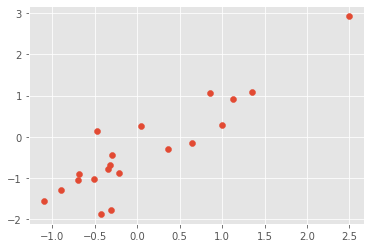

In [27]:
plt.scatter(A[2460,:], A[13, :])

In [28]:
print('Max correlation: ', str(corrA[2460,13]))

Max correlation:  0.902251683691019


Очевидно, что никакой причинно следственной связи в этом нет. Давайте в этом убедимся. Для этого подсчитайте и выведите значение корреляции между X_i и X_j на основе данных их матрицы B. Используйте функцию scipy.stats.pearsonr Отобразите значения найденных переменных X_i и X_j из матрицы B. У Вас должна получиться очень маленькая корреляция.

In [32]:
from scipy.stats import pearsonr

# YOUR CODE HERE
print('Correlation on train:' , pearsonr(B[2460,:], B[13,:])[1])

Correlation on train: 0.16885207078810255


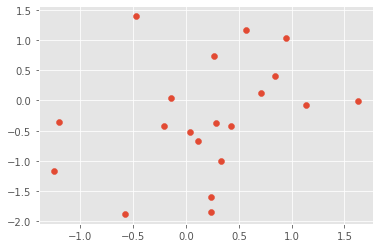

In [31]:
plt.scatter(B[2460,:], B[13, :])

## Задание 2 Методы понижения размерности

Примените методы понижения размерности: PCA, t-SNE и UMAP к изображениям клеток крови из датасета BloodMNIST. Отобразите проекцию данных на две главные компоненты. Какой метод позволяет лучше разделить данные в пространстве? Опишите ваши наблюдения

Произведем загрузку данных:

In [33]:
data_flag = 'bloodmnist'
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(dataset_without_pytorch, info['python_class'])

# load the data
bloodmnist = DataClass(split='train', download=download)
print(bloodmnist)

  0%|          | 0/35461855 [00:00<?, ?it/s]

Dataset BloodMNIST (bloodmnist)
    Number of datapoints: 11959
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'ig', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    License: CC BY 4.0


Доступ к данным идет посредством обращения к ключу blodmnist.imgs, доступ к разметке классов через blodmnist.labels

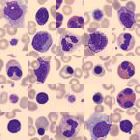

In [124]:
X = bloodmnist.imgs/255.
X = X.reshape(-1, 2352)
y = bloodmnist.labels

bloodmnist.montage(length=5)

In [37]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### PCA

In [46]:
## ENTER YOUR CODE HERE ##
#PCA

pca = sklearn.decomposition.PCA()
pca.fit(X_scaled)
print(pca.explained_variance_ratio_)
#plt.bar(range(titanic_pca.explained_variance_.shape[0]),titanic_pca.explained_variance_)




[2.64638443e-01 9.11509772e-02 4.92954154e-02 ... 3.03003945e-08
 2.97390336e-08 2.87613614e-08]


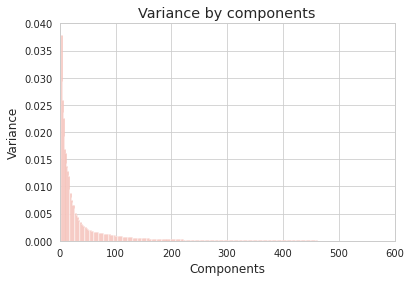

In [47]:
plt.bar(range(pca.explained_variance_ratio_.shape[0]),pca.explained_variance_ratio_)
plt.ylim((0,0.04))
plt.xlim((0,600))
plt.title('Variance by components')
plt.xlabel('Components')
plt.ylabel('Variance')
plt.show()


In [48]:
import os
import tqdm


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import numpy as np
import pandas as pd

from scipy.stats import norm
from sklearn.decomposition import PCA


def shuffle_dataset(dataset):
    random_data =  {}
    for col in dataset.columns:
        random_data[col] = np.random.permutation(dataset.loc[:, col].values)
    random_data = pd.DataFrame(random_data)
    return random_data

def get_variance_by_chance(dataset, n_replics, n_components):
    variance_explained_by_chance = np.zeros((n_replics, n_components))
    for i in tqdm.tqdm_notebook(range(n_replics)):
        if i % 100 == 0:
            print(f"{i} iter")

        random_data = shuffle_dataset(dataset)
        random_pca = PCA(n_components=n_components)
        random_pca.fit(random_data)
        variance_explained_by_chance[i, :] = random_pca.explained_variance_ratio_
    return variance_explained_by_chance

def get_pc_variance(dataset, n_components):
    pca = PCA(n_components=n_components)
    pca.fit(dataset)
    return pca.explained_variance_ratio_

def plot_mean_and_CI(ax, values, label, ci_level=0.95, alpha_transparency=0.5, color_mean=None, color_shading=None):
    mean = values.mean(axis=0)
    
    std = values.std(axis=0)
    n = values.shape[1]
    se = std / np.sqrt(n) 
    
    q_alpha = (1-ci_level) / 2
    ci_num = np.abs(norm.ppf(q_alpha, loc=0, scale=1))
    
    lb = mean -  ci_num * se
    ub = mean + ci_num * se
    
    # plot the shaded range of the confidence intervals
    ax.fill_between(range(mean.shape[0]), ub, lb,
                     color=color_shading, alpha=alpha_transparency)
    # plot the mean on top
    ax.plot(mean, c=color_mean, lw=3, label=label)
    
def plot_explained_variance(ax, variance):
    ax.plot(variance, label='real', lw=3)
    ax.scatter(np.arange(0, variance.shape[0]), variance)
    
def plot_variance_by_change(ax, variance_by_chance):
    plot_mean_and_CI(ax, variance_by_chance, label='chance', color_mean='red', color_shading='red')

def calc_permutat_pval(real_values, permut_values, eps=None):
    eps = eps or (1/(permut_values.shape[0] * 10))
    
    p_values = np.zeros_like(real_values)
    for i in range(0, p_values.shape[0], 1):
        p_values[i] = (permut_values[:, i] >= real_values[i]).mean() + eps
    return p_values

def plot_explained_vs_chance(ax, explained_variance, variance_by_chance, dataset_name, step=1):
    plot_explained_variance(ax, explained_variance)
    plot_variance_by_change(ax, variance_by_chance)

    ax.set_title(f'PCA {dataset_name}', size=35)
    ax.set_xlabel("Component number", size=25)
    ax.set_ylabel("Explained variance ration", size=25)
    ax.set_xticks(np.arange(0, explained_variance.shape[0], step))
    ax.set_xticklabels(np.arange(1, explained_variance.shape[0]+1, step), size=20)

    ax.tick_params(labelsize=20, size=10)
    ax.set_ylim(0, explained_variance[0] + 0.1 )
    ax.legend(fontsize=20)

def plot_pval_plot(ax, p_values, dataset_name, alpha_level = 0.05, logscale=True, step=1):
    if logscale:
        p_values = -np.log10(p_values)
        alpha_level = -np.log10(alpha_level)

    
    ax.set_title(f"PC significance, {dataset_name}", size=35)
    ax.plot(p_values, lw=3)
    ax.scatter(np.arange(0, p_values.shape[0]), p_values, lw=3)

    ax.set_xlabel("Component number", size=25)
    ax.set_ylabel("-log(pvalue + eps)", size=25)
    ax.set_xticks(np.arange(0, p_values.shape[0], step))
    
    ax.set_xticklabels(labels = np.arange(1, p_values.shape[0]+1, step), size=20)
    ax.tick_params(labelsize=20, size=10)
    

    ax.hlines(y=alpha_level, xmin=0, xmax=p_values.shape[0], color="red", linestyles="dashed", lw=3)
    
    
def pca_analysis(ax1, ax2, dataset, title, n_components = None, n_replics = 1000, step=1):
    n_components = n_components or dataset.shape[1]
    explained_variance = get_pc_variance(dataset, n_components)
    variance_by_chance = get_variance_by_chance(dataset, n_replics, n_components)
    p_values = calc_permutat_pval(explained_variance, variance_by_chance)
    plot_explained_vs_chance(ax1, explained_variance, variance_by_chance, title)
    plot_pval_plot(ax2, p_values, title)

  0%|          | 0/10 [00:00<?, ?it/s]

0 iter


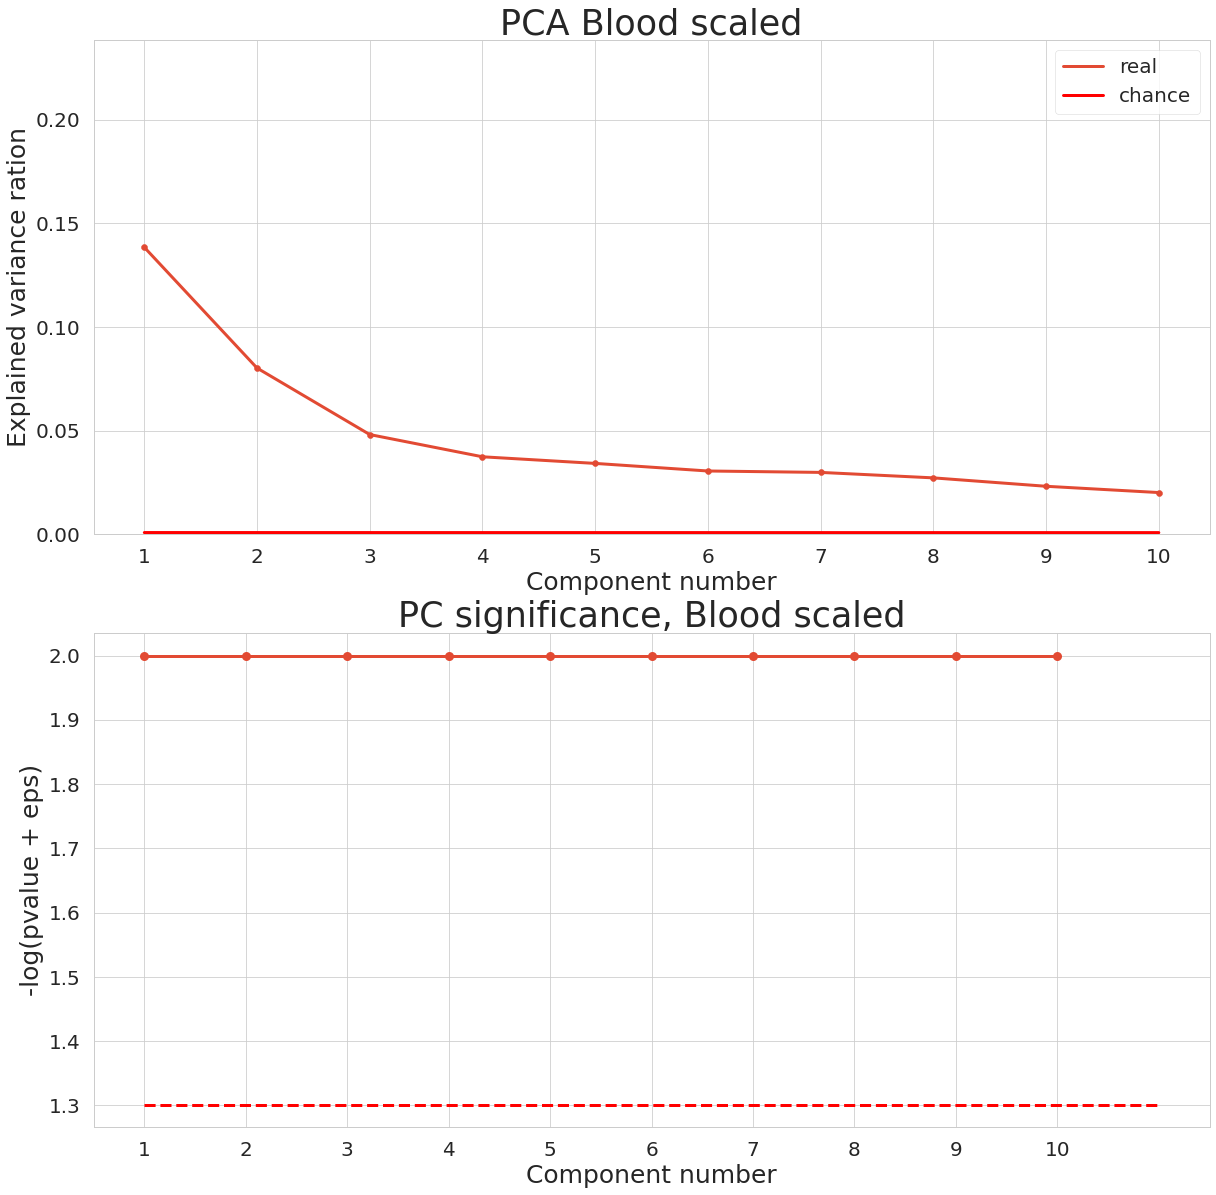

In [50]:
f, (ax1, ax2) = plt.subplots(2, 1)
f.set_figheight(20)
f.set_figwidth(20)
pca_analysis(ax1, ax2, pd.DataFrame(X_scaled), "Blood scaled", n_replics=10, n_components=10)

In [52]:
# выберем число компонент равный 5
pca = sklearn.decomposition.PCA(n_components=5)
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [58]:

y.reshape(-1,11959)[0]

array([7, 3, 6, ..., 1, 6, 4], dtype=uint8)

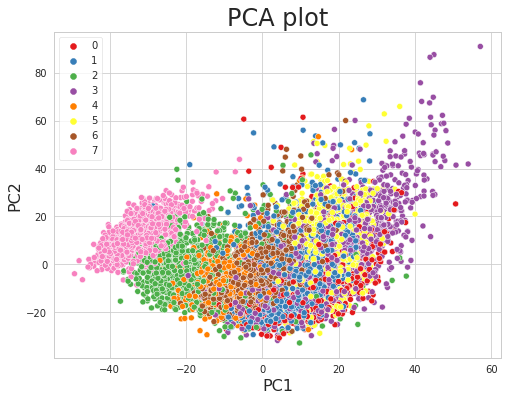

In [62]:
X_reduced = pca.transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.title('PCA plot', size=24)
plt.xlabel('PC1', size=16)
plt.ylabel('PC2', size=16)
sns.scatterplot(x=X_reduced[:, 0],
                y=X_reduced[:, 1], 
                hue=y.reshape(-1,11959)[0], palette='Set1');

Видим, что 7-ая и 2-ая группы довольно неплохо отличаются от остальных групп. Нет полного разделения на классы

### UMAP

In [64]:
from umap import UMAP

In [125]:
# используем PCA из прошлого пункта
model = UMAP(n_components = 2, 
             min_dist = 1, 
             n_neighbors = 20,
             
             # много где, не только он, рекомендуют использовать для инициализации UMAP и tSNE первые две компоненты PCA
             n_epochs = 500, 
             verbose = 2)
umap = model.fit_transform(X)



UMAP(min_dist=1, n_epochs=500, n_neighbors=20, verbose=2)
Sat Oct 30 11:49:56 2021 Construct fuzzy simplicial set
Sat Oct 30 11:49:56 2021 Finding Nearest Neighbors
Sat Oct 30 11:49:57 2021 Building RP forest with 10 trees
Sat Oct 30 11:49:58 2021 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Sat Oct 30 11:50:04 2021 Finished Nearest Neighbor Search
Sat Oct 30 11:50:04 2021 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sat Oct 30 11:50:38 2021 Finished embedding


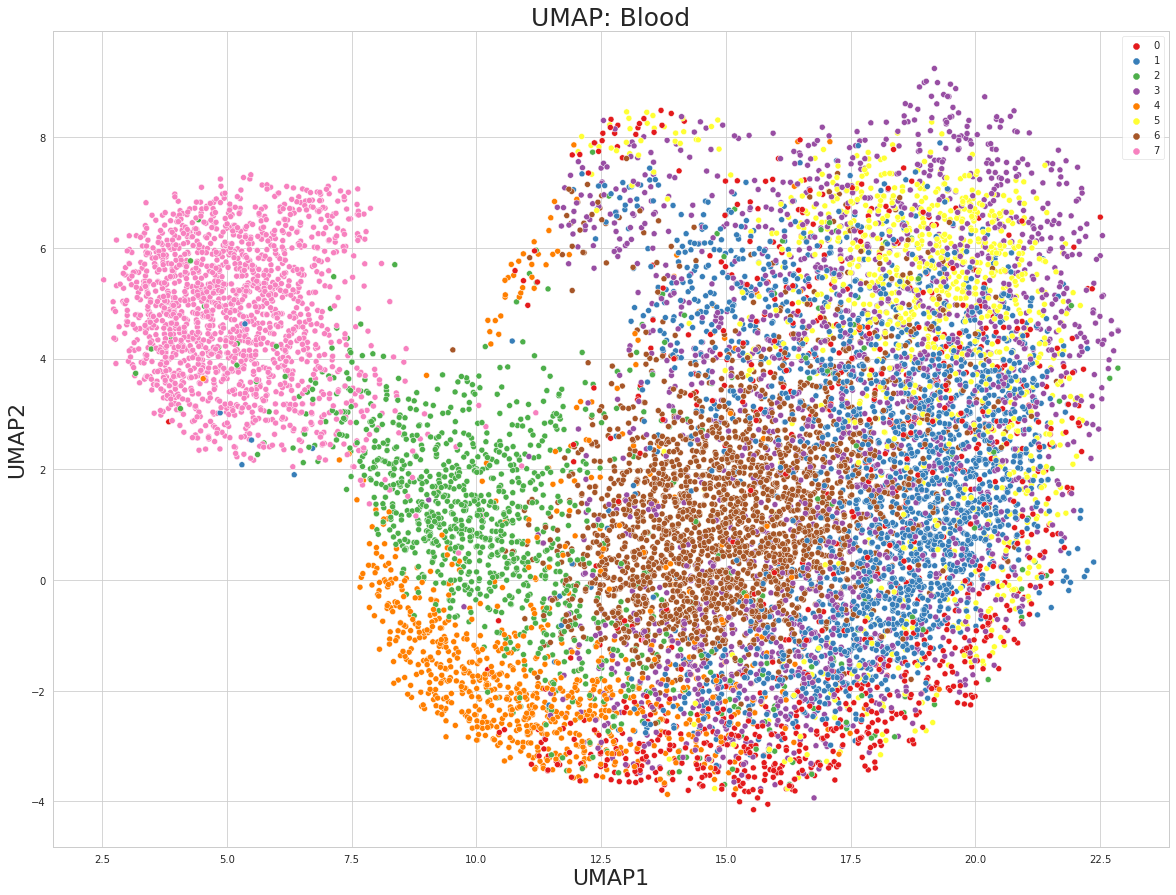

In [126]:
plt.figure(figsize = (20,15))

sns.scatterplot(x=umap[:, 0],
                y=umap[:, 1], 
                hue=y.reshape(-1,11959)[0], palette='Set1')


plt.title('UMAP: Blood', fontsize = 25); 
plt.xlabel("UMAP1", fontsize = 22); plt.ylabel("UMAP2", fontsize = 22)
plt.legend()
plt.show()

Видно, что разделение лучше, чем в PCA. Хорошо отделяются 7,2,4 и 0 кластеры.  6,1 и 5 различимы между собой и практически не пересекаются, а 3-ий распластан между ними

### tSNE

In [127]:
import sklearn.manifold


model = sklearn.manifold.TSNE(n_components = 2, 
            
             perplexity=40, # важный параметр
             verbose = 2)

manifold = model.fit_transform(X)



[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 11959 samples in 4.670s...
[t-SNE] Computed neighbors for 11959 samples in 789.812s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11959
[t-SNE] Computed conditional probabilities for sample 2000 / 11959
[t-SNE] Computed conditional probabilities for sample 3000 / 11959
[t-SNE] Computed conditional probabilities for sample 4000 / 11959
[t-SNE] Computed conditional probabilities for sample 5000 / 11959
[t-SNE] Computed conditional probabilities for sample 6000 / 11959
[t-SNE] Computed conditional probabilities for sample 7000 / 11959
[t-SNE] Computed conditional probabilities for sample 8000 / 11959
[t-SNE] Computed conditional probabilities for sample 9000 / 11959
[t-SNE] Computed conditional probabilities for sample 10000 / 11959
[t-SNE] Computed conditional probabilities for sample 11000 / 11959
[t-SNE] Computed conditional probabilities for sample 11959 / 11959
[t-SNE] Mean sigma: 1.569475
[t-SNE] Computed c

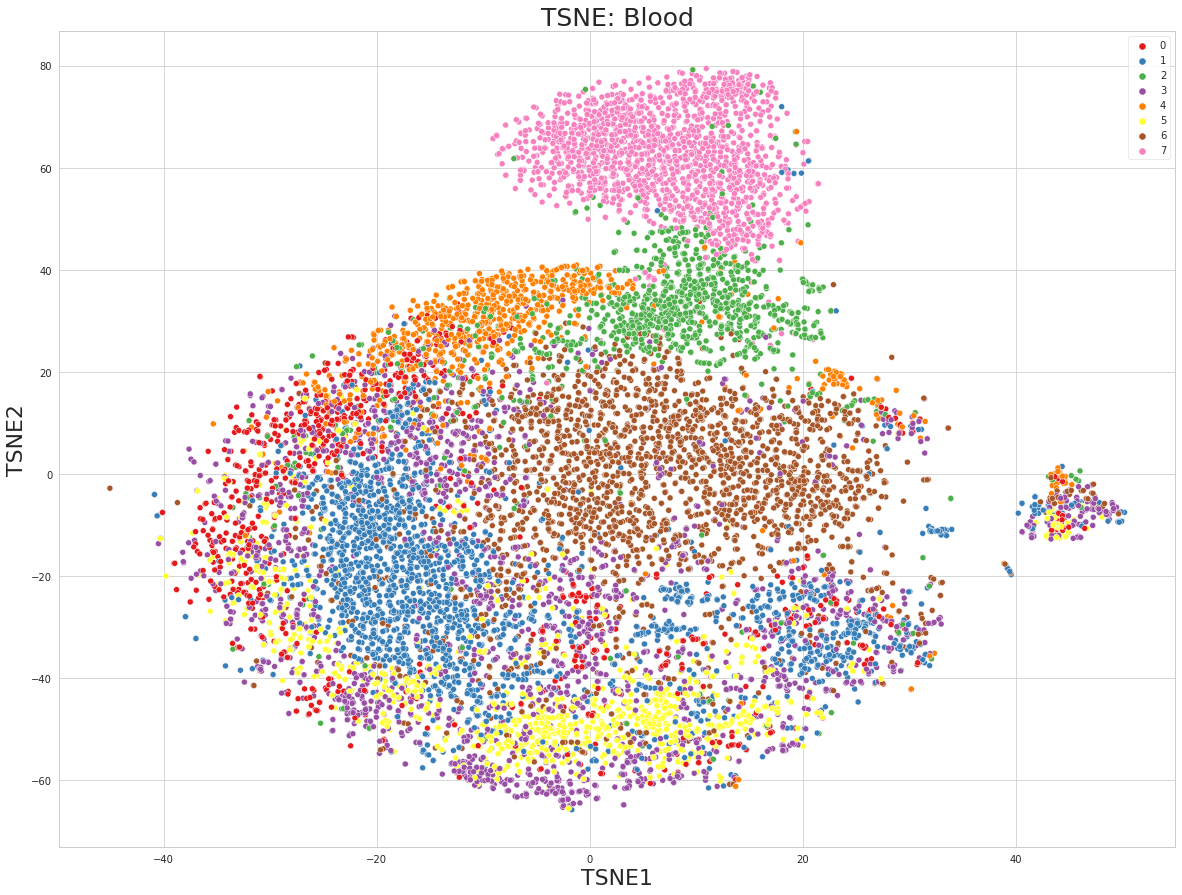

In [128]:
plt.figure(figsize = (20,15))

sns.scatterplot(x=manifold[:, 0],
                y=manifold[:, 1], 
                hue=y.reshape(-1,11959)[0], palette='Set1')


plt.title('TSNE: Blood', fontsize = 25); 
plt.xlabel("TSNE1", fontsize = 22); plt.ylabel("TSNE2", fontsize = 22)
plt.show()

Видно, что 7, 2 и 4 кластеры оказались хорошо отделенными,  6,1 и 5 различимы между собой, а 3-ий накладывается на них.

### Вывод

С помощью PCA получилось отделить только 2 кластера из 8-ми, с помощью UMAP - 5 кластеров. С помощью tSNE также удалось выделить 5 кластеров, однако работал он гораздо дольше UMAP. Однако стоит добавить, что в данном задании я не подбирала гиперпараметры tSNE и UMAP (из соображений времени). Поэтому, возможно, можно подобрать параметры для более оптимального разбиения этих кластеров.

## Задание 3 Feature selection и feature engineering

В этом задании используя датасет с [данными о здоровье плода](https://www.kaggle.com/andrewmvd/fetal-health-classification), сравните различные подходы к отбору признаков. Загрузим датасет:

In [74]:
data = pd.read_csv("fetal_health.csv")
data.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,23.0,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,19.9,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [76]:
data.shape

(2126, 22)

Посмотрим на данные. Видно, что среди представленных признаков довольно много скоррелированных:

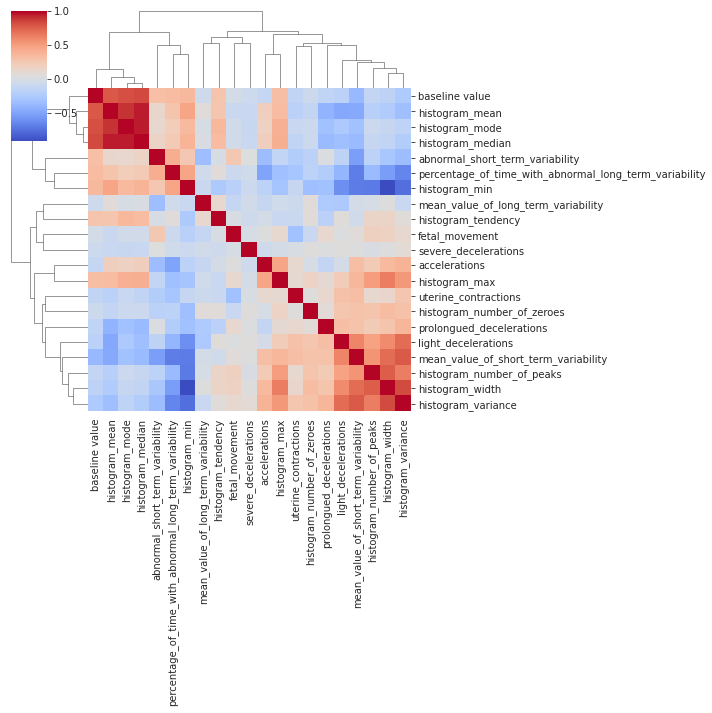

In [75]:
X = data.drop('fetal_health', axis=1)
X = pd.DataFrame(StandardScaler().fit_transform(X),
                 columns=X.columns, index=X.index)
y = data['fetal_health']

corr_matrix = X.corr(method='spearman')
res = sns.clustermap(corr_matrix, method='weighted',
                     figsize=(10, 10), cmap='coolwarm')

Используя жадный отбор признаков, Add Del и PCA, отберите/сгенерируйте от 1 до 20 признаков и сравните на кросс-валидации `accuracy` для моделей `SVC(kernel='rbf')`, получающихся в процессе отбора/генерации признаков. Сравните полученные результаты с `accuracy` модели, обученной с использованием всех имеющихся признаков (на кросс-валидации с тем же количеством фолдов). Изобразите результаты в виде графика, опишите свои наблюдения.

### жадный отбор

In [86]:
sfs = SequentialFeatureSelector(SVC(kernel='rbf'),
                                k_features = 20, scoring='accuracy',
                                cv=5)
sfs.fit(X,y)

df =pd.DataFrame.from_dict(sfs.get_metric_dict()).T


In [87]:
df.head()

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(8,)","[0.8075117370892019, 0.8729411764705882, 0.830...",0.827385,"(mean_value_of_short_term_variability,)",0.0499484,0.0388616,0.0194308
2,"(6, 8)","[0.8192488262910798, 0.8894117647058823, 0.872...",0.858438,"(prolongued_decelerations, mean_value_of_short...",0.0341282,0.0265529,0.0132764
3,"(6, 8, 9)","[0.8802816901408451, 0.8658823529411764, 0.870...",0.868762,"(prolongued_decelerations, mean_value_of_short...",0.0111495,0.00867471,0.00433736
4,"(6, 8, 9, 20)","[0.8615023474178404, 0.88, 0.8752941176470588,...",0.871124,"(prolongued_decelerations, mean_value_of_short...",0.0117635,0.00915242,0.00457621
5,"(5, 6, 8, 9, 20)","[0.8615023474178404, 0.8752941176470588, 0.868...",0.870183,"(severe_decelerations, prolongued_deceleration...",0.00737843,0.00574067,0.00287034


In [90]:
df.shape

(20, 7)

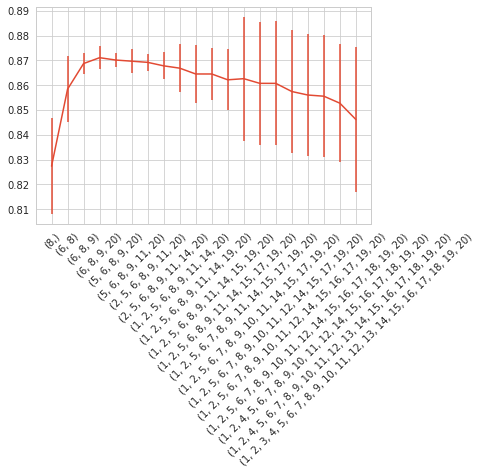

In [92]:
plt.errorbar(np.arange(1, 21),
             df['avg_score'], 
             yerr=df['std_err'])
plt.xticks(np.arange(1, 21), df["feature_idx"],  rotation=45)
plt.show()

Лучшие результаты получились для комбинаций признаков (6,8,9), (6,8,9,20), (5, 6,8,9,20). Однако при добавлении к признакам (6,8,9) резкого скачка качества не происходит, разве что меняется дисперсия accuracy в зависимости от фолдов.

### ADD-DEL

In [96]:
sffs = SequentialFeatureSelector(
          SVC(kernel='rbf'),
           k_features = 20,
           forward=True, 
           floating=True, # use ADD-DEL
           verbose=0,
           scoring='accuracy',
           cv=5)


sffs.fit(X.values,y)
df = pd.DataFrame.from_dict(sffs.get_metric_dict()).T
df.head()

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(8,)","[0.8075117370892019, 0.8729411764705882, 0.830...",0.827385,"(8,)",0.0499484,0.0388616,0.0194308
2,"(6, 8)","[0.8192488262910798, 0.8894117647058823, 0.872...",0.858438,"(6, 8)",0.0341282,0.0265529,0.0132764
3,"(6, 8, 9)","[0.8802816901408451, 0.8658823529411764, 0.870...",0.868762,"(6, 8, 9)",0.0111495,0.00867471,0.00433736
4,"(6, 8, 9, 20)","[0.8615023474178404, 0.88, 0.8752941176470588,...",0.871124,"(6, 8, 9, 20)",0.0117635,0.00915242,0.00457621
5,"(5, 6, 8, 9, 20)","[0.8615023474178404, 0.8752941176470588, 0.868...",0.870183,"(5, 6, 8, 9, 20)",0.00737843,0.00574067,0.00287034


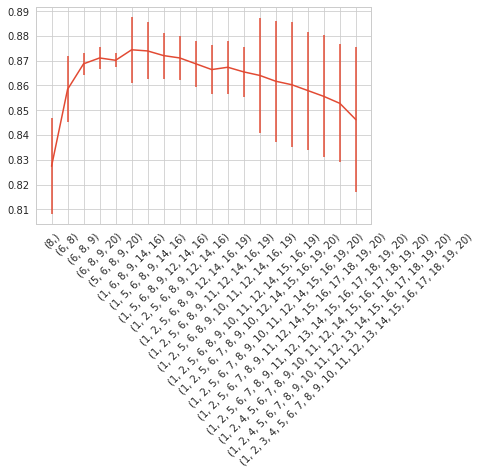

In [97]:
plt.errorbar(np.arange(1, 21),
             df['avg_score'], 
             yerr=df['std_err'])
plt.xticks(np.arange(1, 21), df["feature_idx"],  rotation=45)
plt.show()

Лучший результат получился для комбинаций признаков (6,8,9), (6,8,9,20), (5,6,8,9,20). Средний accuracy примерно одинаковый, но разброс меньше у  этой комбинации (5,6,8,9,20). При добавлении других признаков сначала увеличивается разброс, а потом падает и средняя accuracy.

### PCA  отбор - посмотрим на абсолютный вклад

In [98]:
pca = sklearn.decomposition.PCA()
pca.fit(X)
first_component = pca.components_[0]
second_component = pca.components_[1]

In [105]:
X.shape

(2126, 21)

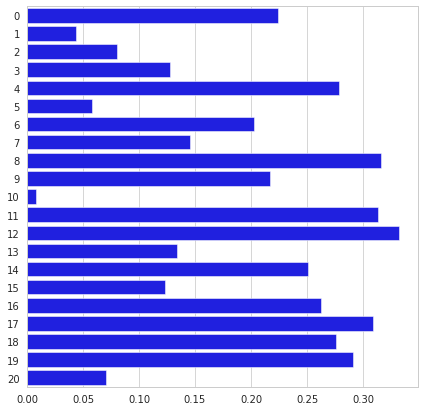

In [113]:
plt.figure(figsize= (7,7))

sns.barplot(x=np.abs(first_component), y=[i for i in range(21)],  orient='h', color='blue')

Наибольший вклад в 1-ую компоненту вносят признаки 8,12,11, 17

In [120]:
pca_feat = [8,12,11,17]
X.iloc[:,pca_feat]

,mean_value_of_short_term_variability,histogram_min,histogram_width,histogram_mean
0,-0.943095,-1.068562,-0.165507,0.153270
1,0.868841,-0.865539,1.529124,0.089126
2,0.868841,-0.865539,1.529124,0.024982
3,1.208579,-1.373097,1.195333,-0.039162
4,1.208579,-1.373097,1.195333,0.089126
...,...,...,...,...
2121,-1.282833,1.469229,-0.781736,0.987141
2122,-1.056341,0.318764,-0.114154,0.858853
2123,-1.056341,0.318764,-0.088478,0.858853
2124,-1.056341,0.318764,-0.114154,0.794709


In [121]:
from sklearn.model_selection import cross_val_score

In [122]:
Xpca = X.iloc[:,pca_feat]
clf = SVC(kernel='rbf')
scores = cross_val_score(clf, Xpca, y, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.84 accuracy with a standard deviation of 0.02


### Полная модель

In [123]:
clf = SVC(kernel='rbf')
scores = cross_val_score(clf, X, y, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.85 accuracy with a standard deviation of 0.06


### Вывод

При отборе признаков с помощью PCA точность практически не отличалась от модели, построенной с использованием всех признаков.При использовании жадного и ADD-DEL отбора качество модели улучшилось примерно одинаково

## Задание 4 Использование понижения размерности для ускорения обучения

Рассмотрите набор данных TissueMNIST. В этом задании вам нужно сравнить производительность двух моделей: обученной с использованием всех доступных признаков и обученной на данных пониженной размерности. От вас требуется:

1. Посторить модель `RandomForestClassifier()` и обучить ее на тренировочной выборке, оценить `accuracy` модели на тестовой выборке и время, потраченное на обучение;
2. Построить модель PCA на тернировочных данных и определите число главных компонент, объясняющих 90% дисперсии (или используйте любой другой способ выбора оптимального числа главных компонент, разбиравшийся на лекции);
3. Спроецировать данные тестовой выборки на главные компоненты, полученной модели PCA;
4. Построить модель `RandomForestClassifier()` и обучить ее на данных пониженной размерности, оценить `accuracy` модели на тестовой выборке и время, потраченное на обучение;
5. Опишите ваши наблюдения, сделайте выводы.

In [129]:
!pip install ipython-autotime

%load_ext autotime

time: 319 µs (started: 2021-10-30 12:10:48 +00:00)


In [130]:
from sklearn.metrics import accuracy_score

time: 1.21 ms (started: 2021-10-30 12:10:48 +00:00)


In [131]:
data_flag = 'tissuemnist'
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(dataset_without_pytorch, info['python_class'])

# load the data
tissuemnist = DataClass(split='test', download=download)
print(tissuemnist)

X = tissuemnist.imgs/255.
X = X.reshape(-1, 784)
y = tissuemnist.labels

tissuemnist.montage(length=5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

  0%|          | 0/124962739 [00:00<?, ?it/s]

Dataset TissueMNIST (tissuemnist)
    Number of datapoints: 47280
    Root location: /root/.medmnist
    Split: test
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'Collecting Duct, Connecting Tubule', '1': 'Distal Convoluted Tubule', '2': 'Glomerular endothelial cells', '3': 'Interstitial endothelial cells', '4': 'Leukocytes', '5': 'Podocytes', '6': 'Proximal Tubule Segments', '7': 'Thick Ascending Limb'}
    Number of samples: {'train': 165466, 'val': 23640, 'test': 47280}
    Description: We use the BBBC051, available from the Broad Bioimage Benchmark Collection. The dataset contains 236,386 human kidney cortex cells, segmented from 3 reference tissue specimens and organized into 8 categories. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. Each gray-scale image is 32×32×7 pixels, where 7 denotes 7 slices. We take maximum values across the slices and resize them into 28×28 gray-scale images.
    License: CC BY 3

### 1 simple rfc

In [132]:
rng = np.random.RandomState(42)
rf = RandomForestClassifier(n_estimators=200, random_state=rng)
rf.fit(X_train, y_train)



AttributeError: ignored

time: 2min 57s (started: 2021-10-30 12:11:03 +00:00)


In [133]:
y_pred = rf.predict(X_test)
accuracy_score(y_test, y_pred)

0.523582910321489

time: 1.1 s (started: 2021-10-30 12:14:50 +00:00)


### 2-4 PCA

  0%|          | 0/10 [00:00<?, ?it/s]

0 iter


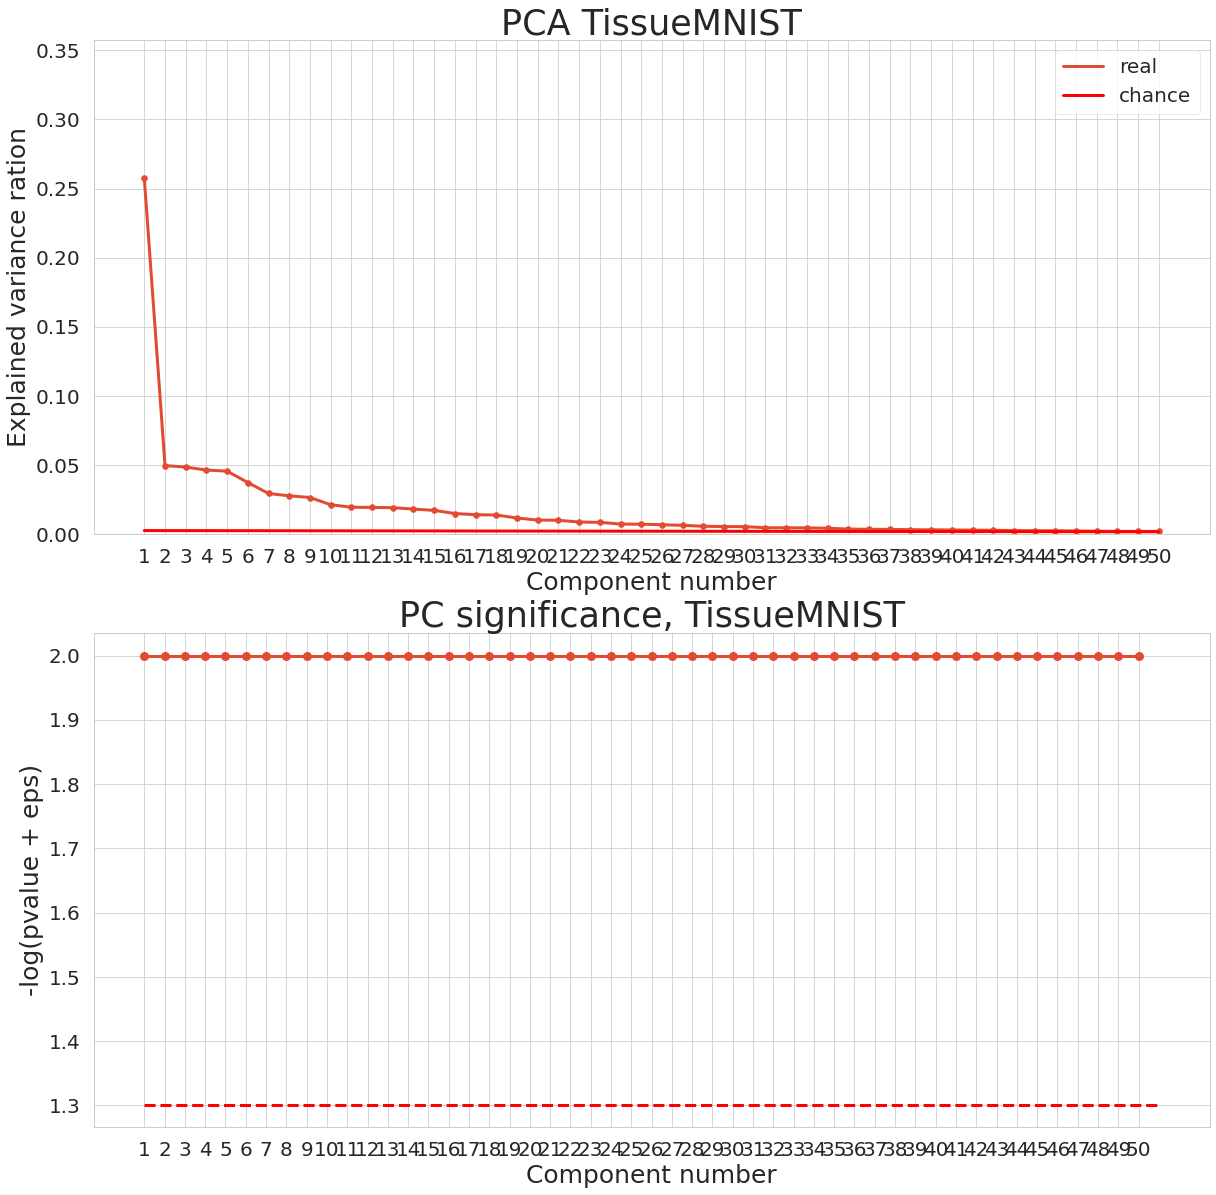

time: 1min 9s (started: 2021-10-30 12:26:13 +00:00)


In [143]:
f, (ax1, ax2) = plt.subplots(2, 1)
f.set_figheight(20)
f.set_figwidth(20)
pca_analysis(ax1, ax2, pd.DataFrame(X_train), "TissueMNIST", n_replics=10, n_components=50)

С использованием перестановочного метода и правила локтя выбираю число компонент 30.

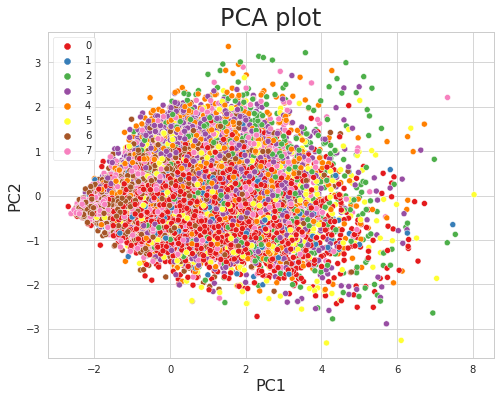

time: 7.67 s (started: 2021-10-30 12:28:27 +00:00)


In [144]:
pca = sklearn.decomposition.PCA(n_components = 30)
pca.fit(X_train)
X_reduced = pca.transform(X_train)

plt.figure(figsize=(8, 6))
plt.title('PCA plot', size=24)
plt.xlabel('PC1', size=16)
plt.ylabel('PC2', size=16)
sns.scatterplot(x=X_reduced[:, 0],
                y=X_reduced[:, 1], 
                hue=y_train.reshape(-1,37824)[0], palette='Set1');

Можно заметить, что кластеры довольно плохо отделяются

In [145]:
X_test_reduced = pca.transform(X_test)

time: 86.7 ms (started: 2021-10-30 12:28:36 +00:00)


In [146]:
rf = RandomForestClassifier(n_estimators=200, random_state=rng)
rf.fit(X_reduced, y_train)
y_pred = rf.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.5041243654822335

time: 1min 6s (started: 2021-10-30 12:28:36 +00:00)


### 5 Вывод

Точность классификатора, построенного на данных с пониженной размерностью меньше, чем классификатора, построенного на полных данных. Это ожидаемый результат, так как визуально первые 2 компоненты PCA плохо отделяют данные.Однако второй классификатор обучился в 3 раза быстрее.